# Introduction

Goals:

* Measure the amount of movement in the peptide
* Measure the amount of movement in TCR contact positions 

In [1]:
import glob
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from python_pdb.parsers import parse_pdb_to_pandas
from python_pdb.comparisons import rmsd
from sklearn.linear_model import LinearRegression

In [2]:
DATA_DIR = '/project/koohylab/bmcmaste/projects/tcr-pmhc-interface-analysis/data/apo-holo_TCR_pMHC_TCR-pMHC_structures_renumbered_aligned'

In [3]:
df = pd.DataFrame(glob.glob('**/*.pdb', root_dir=DATA_DIR, recursive=True), columns=['path'])
df

,path
0,hla_a_02_01_gilglvftl_SVFSS-VVTGGEV-AGAGSQGNLI...
1,hla_a_02_01_gilglvftl_SVFSS-VVTGGEV-AGAGSQGNLI...
2,hla_a_02_01_gilglvftl_SVFSS-VVTGGEV-AGAGSQGNLI...
3,hla_a_02_01_slyntvatl_DRGSQS-IYSNGD-AVRTNSGYAL...
4,hla_a_02_01_slyntvatl_DRGSQS-IYSNGD-AVRTNSGYAL...
...,...
165,hla_b_07_02_aprgphggaasgl_NIATNDY-GYKTK-LVGEIL...
166,hla_b_07_02_aprgphggaasgl_NIATNDY-GYKTK-LVGEIL...
167,hla_a_02_01_yqfgpdfpia_NSAFQY-TYSSGN-AMRGDSSYK...
168,hla_a_02_01_yqfgpdfpia_NSAFQY-TYSSGN-AMRGDSSYK...


In [4]:
def get_chains(name):
    if name.startswith('pmhc_'):
        return {'alpha_chain': None, 'beta_chain': None, 'antigen_chain': 'C', 'mhc_chain': 'A'}
    
    if name.startswith('tcr_'):
        chains = name.split('.')[0].split('_')[2]
        return {'alpha_chain': chains[0], 'beta_chain': chains[1], 'antigen_chain': None, 'mhc_chain': None}
    
    if name.startswith('tcr-pmhc_'):
        chains = name.split('.')[0].split('_')[2]
        return {'alpha_chain': chains[0], 'beta_chain': chains[1], 'antigen_chain': chains[2], 'mhc_chain': chains[3]}

df[['group_name', 'aligned_to', 'name']] = df['path'].map(lambda path: path.split('/')).apply(pd.Series)
df[['molecule_type', 'pdb_id']] = df['name'].map(lambda name: name.split('.')[0].split('_')[0:2]).apply(pd.Series)
df[['alpha_chain', 'beta_chain', 'antigen_chain', 'mhc_chain']] = df['name'].map(get_chains).apply(pd.Series)

# Don't need TCR information
df = df.query("molecule_type != 'tcr'").copy().reset_index(drop=True)

df

,path,group_name,aligned_to,name,molecule_type,pdb_id,alpha_chain,beta_chain,antigen_chain,mhc_chain
0,hla_a_02_01_gilglvftl_SVFSS-VVTGGEV-AGAGSQGNLI...,hla_a_02_01_gilglvftl_SVFSS-VVTGGEV-AGAGSQGNLI...,tcr-pmhc_5hhm_IJHF,pmhc_5hhn.pdb,pmhc,5hhn,None,None,C,A
1,hla_a_02_01_gilglvftl_SVFSS-VVTGGEV-AGAGSQGNLI...,hla_a_02_01_gilglvftl_SVFSS-VVTGGEV-AGAGSQGNLI...,tcr-pmhc_5hhm_IJHF,tcr-pmhc_5hhm_IJHF.pdb,tcr-pmhc,5hhm,I,J,H,F
2,hla_a_02_01_slyntvatl_DRGSQS-IYSNGD-AVRTNSGYAL...,hla_a_02_01_slyntvatl_DRGSQS-IYSNGD-AVRTNSGYAL...,tcr-pmhc_5nme_IJHF,tcr-pmhc_5nme_IJHF.pdb,tcr-pmhc,5nme,I,J,H,F
3,hla_a_02_01_slyntvatl_DRGSQS-IYSNGD-AVRTNSGYAL...,hla_a_02_01_slyntvatl_DRGSQS-IYSNGD-AVRTNSGYAL...,tcr-pmhc_5nme_IJHF,pmhc_1t22.pdb,pmhc,1t22,None,None,C,A
4,hla_a_02_01_slyntvatl_DRGSQS-IYSNGD-AVRTNSGYAL...,hla_a_02_01_slyntvatl_DRGSQS-IYSNGD-AVRTNSGYAL...,tcr-pmhc_5nme_IJHF,pmhc_1t21.pdb,pmhc,1t21,None,None,C,A
...,...,...,...,...,...,...,...,...,...,...
120,hla_b_44_05_eeylqafty_TISGTDY-GLTSN-ILPLAGGTSY...,hla_b_44_05_eeylqafty_TISGTDY-GLTSN-ILPLAGGTSY...,tcr-pmhc_3kps_DECA,pmhc_3kpp.pdb,pmhc,3kpp,None,None,C,A
121,hla_b_07_02_aprgphggaasgl_NIATNDY-GYKTK-LVGEIL...,hla_b_07_02_aprgphggaasgl_NIATNDY-GYKTK-LVGEIL...,tcr-pmhc_6avf_ABPH,pmhc_6at5.pdb,pmhc,6at5,None,None,C,A
122,hla_b_07_02_aprgphggaasgl_NIATNDY-GYKTK-LVGEIL...,hla_b_07_02_aprgphggaasgl_NIATNDY-GYKTK-LVGEIL...,tcr-pmhc_6avf_ABPH,tcr-pmhc_6avf_ABPH.pdb,tcr-pmhc,6avf,A,B,P,H
123,hla_a_02_01_yqfgpdfpia_NSAFQY-TYSSGN-AMRGDSSYK...,hla_a_02_01_yqfgpdfpia_NSAFQY-TYSSGN-AMRGDSSYK...,tcr-pmhc_5c07_DECA,tcr-pmhc_5c07_DECA.pdb,tcr-pmhc,5c07,D,E,C,A


In [5]:
def get_coords(df):
    return df[['pos_x', 'pos_y', 'pos_z']].to_numpy()

# Peptide movement

In [6]:
group_names = []
apo_paths = []
holo_paths = []
residue_names = []
residue_seq_ids = []
residue_insert_codes = []
residue_positions = []
peptide_lengths = []
rmsds = []

for (group_name, aligned_name), group in df.groupby(['group_name', 'aligned_to']):
    apo_structures = group.query("molecule_type == 'pmhc'")
    holo_structure_info = group.query("molecule_type == 'tcr-pmhc'").iloc[0]
    
    with open(os.path.join(DATA_DIR, holo_structure_info['path']), 'r') as fh:
        holo_df = parse_pdb_to_pandas(fh.read())
    
    holo_peptide_df = holo_df.query('chain_id == @holo_structure_info.antigen_chain')
    
    for _, apo_structure_info in apo_structures.iterrows():
        with open(os.path.join(DATA_DIR, apo_structure_info['path']), 'r') as fh:
            apo_df = parse_pdb_to_pandas(fh.read())
    
        apo_peptide_df = apo_df.query('chain_id == @apo_structure_info.antigen_chain')
        
        apo_group = apo_peptide_df.groupby(['residue_name', 'residue_seq_id', 'residue_insert_code'], dropna=False)
        holo_group = holo_peptide_df.groupby(['residue_name', 'residue_seq_id', 'residue_insert_code'], dropna=False)
        
        pep_rmsds = []
        pep_positions = []
        pep_res_names = []
        pep_seq_ids = []
        pep_insert_codes = []
        for position, (((res_name, seq_id, insert_code), apo_res), (_, holo_res)) in enumerate(zip(apo_group, holo_group), 1):
            try:
                pep_rmsds.append(rmsd(get_coords(apo_res), get_coords(holo_res)))
            except ValueError:
                print('Mismatched number of atoms in residue:')
                print(apo_structure_info['path'], holo_structure_info['path'], res_name, seq_id, insert_code)
                pep_rmsds.append(None)
            
            pep_positions.append(position)
            pep_res_names.append(res_name)
            pep_seq_ids.append(seq_id)
            pep_insert_codes.append(insert_code)
        
        num_residues = len(pep_rmsds)
        
        group_names += [group_name] * num_residues
        apo_paths += [apo_structure_info['path']] * num_residues
        holo_paths += [holo_structure_info['path']] * num_residues
        
        residue_positions += pep_positions
        residue_names += pep_res_names
        residue_seq_ids += pep_seq_ids
        residue_insert_codes += pep_insert_codes

        peptide_lengths += [num_residues] * num_residues
        
        rmsds += pep_rmsds

peptide_results = pd.DataFrame({
    'group_name': group_names,
    'apo_path': apo_paths,
    'holo_path': holo_paths,
    'residue_name': residue_names,
    'residue_seq_id': residue_seq_ids,
    'residue_insert_code': residue_insert_codes,
    'residue_position': residue_positions,
    'peptide_length': peptide_lengths,
    'rmsd': rmsds,
})
peptide_results

Mismatched number of atoms in residue:
h2_dd_rgpgrafvti_NSAFDY-ILSVSNK-AASASFGDNSKLI-MSHET-SYDVDS-ASSLGHTEVF/tcr-pmhc_5ivx_EFPA/pmhc_3ecb.pdb h2_dd_rgpgrafvti_NSAFDY-ILSVSNK-AASASFGDNSKLI-MSHET-SYDVDS-ASSLGHTEVF/tcr-pmhc_5ivx_EFPA/tcr-pmhc_5ivx_EFPA.pdb ILE 10 nan
Mismatched number of atoms in residue:
hla_a_02_01_gilgfvftl_SVFSS-VVTGGEV-AGAGSQGNLI-LNHDA-SQIVND-ASSSRSSYEQY/tcr-pmhc_2vlj_DECA/pmhc_1hhi.pdb hla_a_02_01_gilgfvftl_SVFSS-VVTGGEV-AGAGSQGNLI-LNHDA-SQIVND-ASSSRSSYEQY/tcr-pmhc_2vlj_DECA/tcr-pmhc_2vlj_DECA.pdb LEU 9 nan
Mismatched number of atoms in residue:
hla_a_02_01_gilgfvftl_SVFSS-VVTGGEV-AGAGSQGNLI-LNHDA-SQIVND-ASSSRSSYEQY/tcr-pmhc_2vlj_DECA/pmhc_2vll.pdb hla_a_02_01_gilgfvftl_SVFSS-VVTGGEV-AGAGSQGNLI-LNHDA-SQIVND-ASSSRSSYEQY/tcr-pmhc_2vlj_DECA/tcr-pmhc_2vlj_DECA.pdb LEU 9 nan
Mismatched number of atoms in residue:
hla_a_02_01_gilgfvftl_SVFSS-VVTGGEV-AGAGSQGNLI-LNHDA-SQIVND-ASSSRSSYEQY/tcr-pmhc_2vlk_DECA/pmhc_1hhi.pdb hla_a_02_01_gilgfvftl_SVFSS-VVTGGEV-AGAGSQGNLI-LNHDA-SQ

,group_name,apo_path,holo_path,residue_name,residue_seq_id,residue_insert_code,residue_position,peptide_length,rmsd
0,h2_dd_rgpgrafvti_NSAFDY-ILSVSNK-AASASFGDNSKLI-...,h2_dd_rgpgrafvti_NSAFDY-ILSVSNK-AASASFGDNSKLI-...,h2_dd_rgpgrafvti_NSAFDY-ILSVSNK-AASASFGDNSKLI-...,ALA,6,NaN,1,10,0.961446
1,h2_dd_rgpgrafvti_NSAFDY-ILSVSNK-AASASFGDNSKLI-...,h2_dd_rgpgrafvti_NSAFDY-ILSVSNK-AASASFGDNSKLI-...,h2_dd_rgpgrafvti_NSAFDY-ILSVSNK-AASASFGDNSKLI-...,ARG,1,NaN,2,10,1.838192
2,h2_dd_rgpgrafvti_NSAFDY-ILSVSNK-AASASFGDNSKLI-...,h2_dd_rgpgrafvti_NSAFDY-ILSVSNK-AASASFGDNSKLI-...,h2_dd_rgpgrafvti_NSAFDY-ILSVSNK-AASASFGDNSKLI-...,ARG,5,NaN,3,10,1.570423
3,h2_dd_rgpgrafvti_NSAFDY-ILSVSNK-AASASFGDNSKLI-...,h2_dd_rgpgrafvti_NSAFDY-ILSVSNK-AASASFGDNSKLI-...,h2_dd_rgpgrafvti_NSAFDY-ILSVSNK-AASASFGDNSKLI-...,GLY,2,NaN,4,10,0.258339
4,h2_dd_rgpgrafvti_NSAFDY-ILSVSNK-AASASFGDNSKLI-...,h2_dd_rgpgrafvti_NSAFDY-ILSVSNK-AASASFGDNSKLI-...,h2_dd_rgpgrafvti_NSAFDY-ILSVSNK-AASASFGDNSKLI-...,GLY,4,NaN,5,10,0.648842
...,...,...,...,...,...,...,...,...,...
741,hla_b_53_01_qasqevknw_DSAIYN-IQSSQRE-AQLNQAGTA...,hla_b_53_01_qasqevknw_DSAIYN-IQSSQRE-AQLNQAGTA...,hla_b_53_01_qasqevknw_DSAIYN-IQSSQRE-AQLNQAGTA...,GLU,5,NaN,5,9,NaN
742,hla_b_53_01_qasqevknw_DSAIYN-IQSSQRE-AQLNQAGTA...,hla_b_53_01_qasqevknw_DSAIYN-IQSSQRE-AQLNQAGTA...,hla_b_53_01_qasqevknw_DSAIYN-IQSSQRE-AQLNQAGTA...,LYS,7,NaN,6,9,0.679370
743,hla_b_53_01_qasqevknw_DSAIYN-IQSSQRE-AQLNQAGTA...,hla_b_53_01_qasqevknw_DSAIYN-IQSSQRE-AQLNQAGTA...,hla_b_53_01_qasqevknw_DSAIYN-IQSSQRE-AQLNQAGTA...,SER,3,NaN,7,9,0.329385
744,hla_b_53_01_qasqevknw_DSAIYN-IQSSQRE-AQLNQAGTA...,hla_b_53_01_qasqevknw_DSAIYN-IQSSQRE-AQLNQAGTA...,hla_b_53_01_qasqevknw_DSAIYN-IQSSQRE-AQLNQAGTA...,TRP,9,NaN,8,9,0.451805


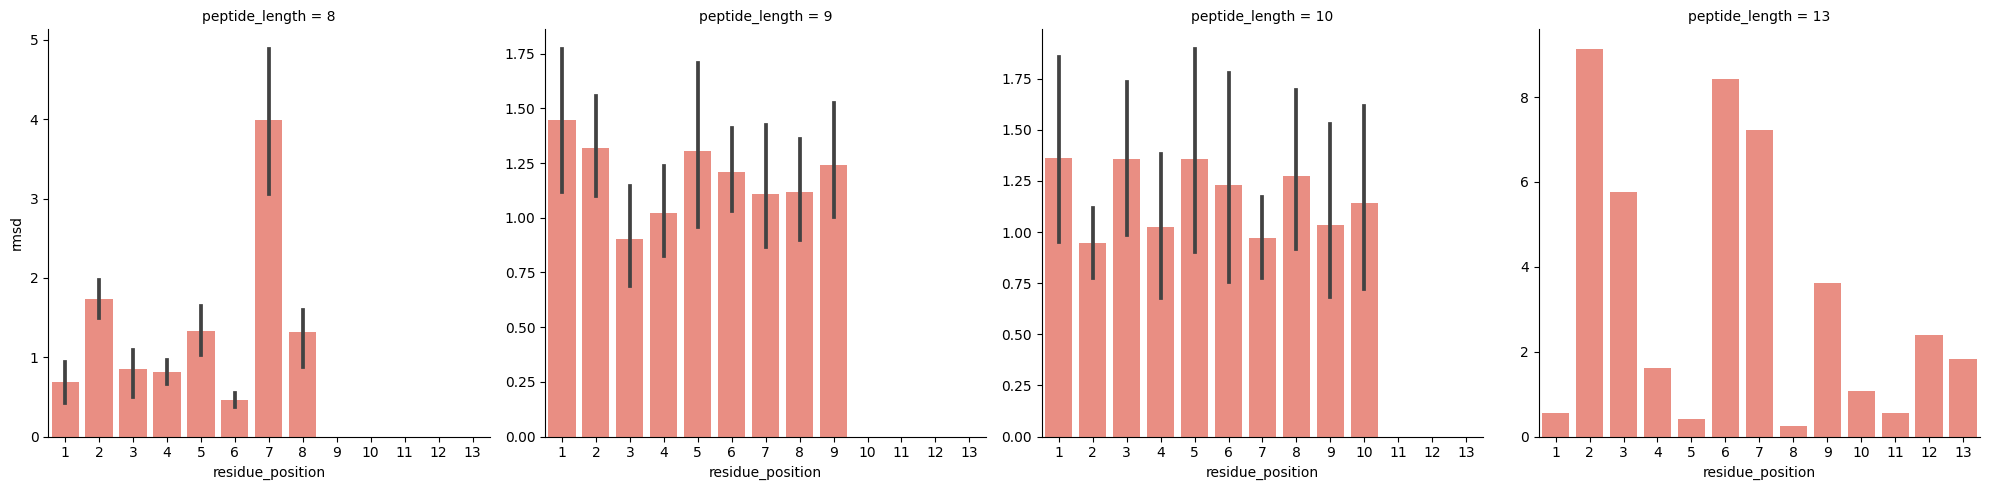

In [7]:
sns.catplot(peptide_results,
            col='peptide_length',
            x='residue_position',
            y='rmsd',
            color='salmon',
            kind='bar',
            sharey=False)
# plt.savefig('figures/peptide-rmsd.svg')

In [10]:
peptide_results.drop_duplicates(['apo_path', 'holo_path'])['peptide_length'].value_counts()

peptide_length
9     49
10    26
8      4
13     1
Name: count, dtype: int64

In [19]:
sns.catplot(peptide_results.query('peptide_length == 9'),
            row='group_name',
            x='residue_position',
            y='rmsd',
            color='salmon',
            kind='bar',
            sharey=False,
            sharex=False)

/package/python-cbrg/current/3.11/lib/python3.11/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/package/python-cbrg/current/3.11/lib/python3.11/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/package/python-cbrg/current/3.11/lib/python3.11/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))


# Exploring Side vs Mid Anchored residues

(0.0, 3.0)

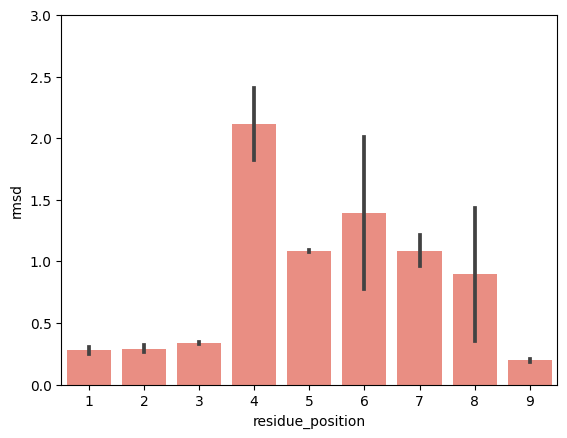

In [49]:
sns.barplot(peptide_results.query("group_name == 'hla_a_02_01_aagigiltv_DRGSQS-IYSNGD-AVNFGGGKLI-MRHNA-SNTAGT-ASSLSFGTEAF'"),
            x='residue_position',
            y='rmsd',
            color='salmon')
plt.ylim(0.0, 3.0)
# plt.savefig('figures/peptide-side-anchor-rmsd.svg')

/package/python-cbrg/current/3.11/lib/python3.11/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))


(0.0, 3.0)

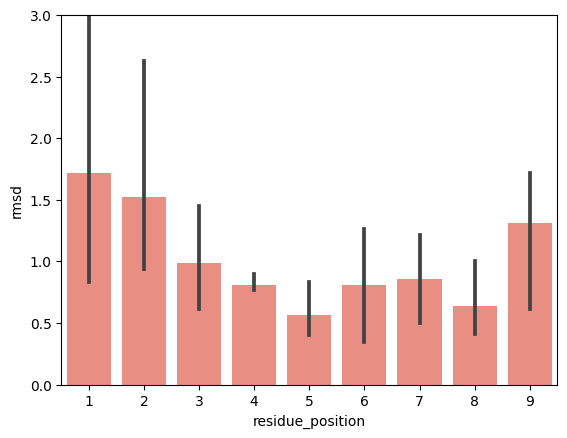

In [50]:
sns.barplot(peptide_results.query("group_name == 'hla_b_08_01_flrgraygl_TISGTDY-GLTSN-ILPLAGGTSYGKLT-SGHVS-FQNEAQ-ASSLGQAYEQY'"),
            x='residue_position',
            y='rmsd',
            color='salmon')
plt.ylim(0.0, 3.0)
# plt.savefig('figures/peptide-mid-anchor-rmsd.svg')

/package/python-cbrg/current/3.11/lib/python3.11/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))


<Axes: xlabel='residue_position', ylabel='rmsd'>

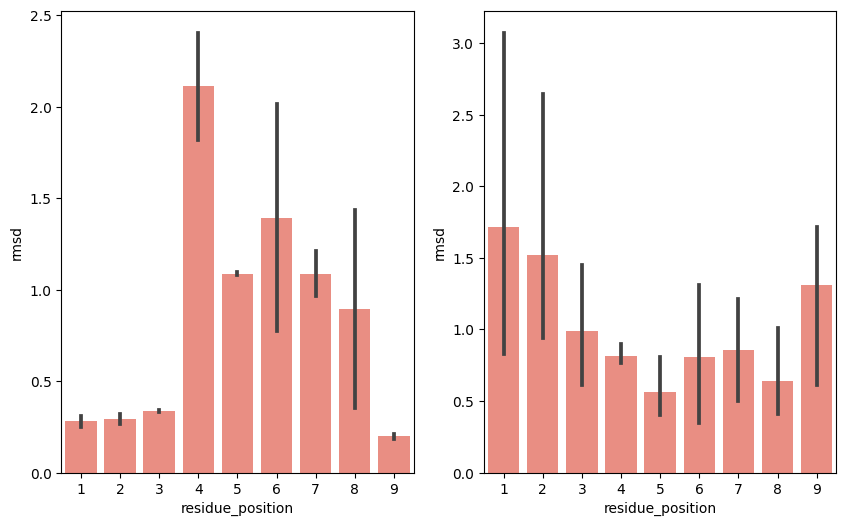

In [51]:
fig, ax = plt.subplots(1, 2, figsize=(10, 6))

sns.barplot(peptide_results.query("group_name == 'hla_a_02_01_aagigiltv_DRGSQS-IYSNGD-AVNFGGGKLI-MRHNA-SNTAGT-ASSLSFGTEAF'"),
            x='residue_position',
            y='rmsd',
            color='salmon',
            ax=ax[0])

sns.barplot(peptide_results.query("group_name == 'hla_b_08_01_flrgraygl_TISGTDY-GLTSN-ILPLAGGTSYGKLT-SGHVS-FQNEAQ-ASSLGQAYEQY'"),
            x='residue_position',
            y='rmsd',
            color='salmon',
            ax=ax[1])

# TCR contact position movement

Contact positions have been taken from analysis of the interface in a different notebook.

In [61]:
contact_positions = ['1066',
                     '65',
                     '72',
                     '66',
                     '1061A',
                     '1062',
                     '69',
                     '1065',
                     '76',
                     '62',
                     '73',
                     '1077',
                     '1073',
                     '1069',
                     '75',
                     '1058',
                     '68',
                     '1070',
                     '58',
                     '1063',
                     '1076',
                     '1080',
                     '79',
                     '1061',
                     '70',
                     '1059']

In [108]:
group_names = []
apo_paths = []
holo_paths = []
residue_names = []
residue_seq_ids = []
residue_insert_codes = []
resis = []
rmsds = []

for (group_name, aligned_name), group in df.groupby(['group_name', 'aligned_to']):
    apo_structures = group.query("molecule_type == 'pmhc'")
    holo_structure_info = group.query("molecule_type == 'tcr-pmhc'").iloc[0]
    
    with open(os.path.join(DATA_DIR, holo_structure_info['path']), 'r') as fh:
        holo_df = parse_pdb_to_pandas(fh.read())
    
    holo_df['resi'] = holo_df['residue_seq_id'].apply(str) + holo_df['residue_insert_code'].fillna('')
    
    holo_mhc_contacts_df = holo_df.query(
        'chain_id == @holo_structure_info.mhc_chain and resi in @contact_positions'
    )
    
    for _, apo_structure_info in apo_structures.iterrows():
        with open(os.path.join(DATA_DIR, apo_structure_info['path']), 'r') as fh:
            apo_df = parse_pdb_to_pandas(fh.read())
        
        apo_df['resi'] = apo_df['residue_seq_id'].apply(str) + apo_df['residue_insert_code'].fillna('')
        
        apo_mhc_contacts_df = apo_df.query('chain_id == @apo_structure_info.mhc_chain and resi in @contact_positions')
        
        apo_group = apo_mhc_contacts_df.groupby(['residue_name', 'resi', 'residue_seq_id'], dropna=False)
        holo_group = holo_mhc_contacts_df.groupby(['residue_name', 'resi', 'residue_seq_id'], dropna=False)
        
        mhc_rmsds = []
        mhc_res_names = []
        mhc_res_seq_ids = []
        mhc_res_insert_codes = []
        mhc_resis = []
        
        overlap = holo_mhc_contacts_df.merge(apo_mhc_contacts_df,
                                   on=['record_type', 'resi', 'residue_seq_id', 'residue_insert_code', 'residue_name', 'atom_name', 'alt_loc'],
                                   how='inner',
                                   suffixes=['_holo', '_apo'])
        
        for (res_name, res_seq_id, res_insert_code, resi), residue_df in overlap.groupby(['residue_name', 'residue_seq_id', 'residue_insert_code', 'resi'], dropna=False):
            mhc_rmsds.append(rmsd(residue_df[['pos_x_apo', 'pos_y_apo', 'pos_z_apo']].to_numpy(),
                                  residue_df[['pos_x_holo', 'pos_y_holo', 'pos_z_holo']].to_numpy()))
            
            mhc_res_names.append(res_name)
            mhc_res_seq_ids.append(res_seq_id)
            mhc_res_insert_codes.append(res_insert_code)
            mhc_resis.append(resi)
        
        num_residues = len(mhc_rmsds)
        
        group_names += [group_name] * num_residues
        apo_paths += [apo_structure_info['path']] * num_residues
        holo_paths += [holo_structure_info['path']] * num_residues
        
        residue_names += mhc_res_names
        mhc_res_seq_ids
        residue_seq_ids += mhc_res_seq_ids
        residue_insert_codes += mhc_res_insert_codes
        resis += mhc_resis
        
        rmsds += mhc_rmsds

mhc_contact_results = pd.DataFrame({
    'group_name': group_names,
    'apo_path': apo_paths,
    'holo_path': holo_paths,
    'residue_name': residue_names,
    'residue_seq_id': residue_seq_ids,
    'residue_insert_code': residue_insert_codes,
    'resi': resis,
    'rmsd': rmsds,
})
mhc_contact_results

,group_name,apo_path,holo_path,residue_name,residue_seq_id,residue_insert_code,resi,rmsd
0,h2_dd_rgpgrafvti_NSAFDY-ILSVSNK-AASASFGDNSKLI-...,h2_dd_rgpgrafvti_NSAFDY-ILSVSNK-AASASFGDNSKLI-...,h2_dd_rgpgrafvti_NSAFDY-ILSVSNK-AASASFGDNSKLI-...,ALA,1061,A,1061A,0.512783
1,h2_dd_rgpgrafvti_NSAFDY-ILSVSNK-AASASFGDNSKLI-...,h2_dd_rgpgrafvti_NSAFDY-ILSVSNK-AASASFGDNSKLI-...,h2_dd_rgpgrafvti_NSAFDY-ILSVSNK-AASASFGDNSKLI-...,ALA,1063,NaN,1063,0.635377
2,h2_dd_rgpgrafvti_NSAFDY-ILSVSNK-AASASFGDNSKLI-...,h2_dd_rgpgrafvti_NSAFDY-ILSVSNK-AASASFGDNSKLI-...,h2_dd_rgpgrafvti_NSAFDY-ILSVSNK-AASASFGDNSKLI-...,ALA,1069,NaN,1069,0.359670
3,h2_dd_rgpgrafvti_NSAFDY-ILSVSNK-AASASFGDNSKLI-...,h2_dd_rgpgrafvti_NSAFDY-ILSVSNK-AASASFGDNSKLI-...,h2_dd_rgpgrafvti_NSAFDY-ILSVSNK-AASASFGDNSKLI-...,ARG,62,NaN,62,1.929916
4,h2_dd_rgpgrafvti_NSAFDY-ILSVSNK-AASASFGDNSKLI-...,h2_dd_rgpgrafvti_NSAFDY-ILSVSNK-AASASFGDNSKLI-...,h2_dd_rgpgrafvti_NSAFDY-ILSVSNK-AASASFGDNSKLI-...,ARG,65,NaN,65,4.051931
...,...,...,...,...,...,...,...,...
2041,hla_b_53_01_qasqevknw_DSAIYN-IQSSQRE-AQLNQAGTA...,hla_b_53_01_qasqevknw_DSAIYN-IQSSQRE-AQLNQAGTA...,hla_b_53_01_qasqevknw_DSAIYN-IQSSQRE-AQLNQAGTA...,THR,73,NaN,73,1.283725
2042,hla_b_53_01_qasqevknw_DSAIYN-IQSSQRE-AQLNQAGTA...,hla_b_53_01_qasqevknw_DSAIYN-IQSSQRE-AQLNQAGTA...,hla_b_53_01_qasqevknw_DSAIYN-IQSSQRE-AQLNQAGTA...,TRP,1059,NaN,1059,0.247024
2043,hla_b_53_01_qasqevknw_DSAIYN-IQSSQRE-AQLNQAGTA...,hla_b_53_01_qasqevknw_DSAIYN-IQSSQRE-AQLNQAGTA...,hla_b_53_01_qasqevknw_DSAIYN-IQSSQRE-AQLNQAGTA...,TRP,1077,NaN,1077,0.297190
2044,hla_b_53_01_qasqevknw_DSAIYN-IQSSQRE-AQLNQAGTA...,hla_b_53_01_qasqevknw_DSAIYN-IQSSQRE-AQLNQAGTA...,hla_b_53_01_qasqevknw_DSAIYN-IQSSQRE-AQLNQAGTA...,TYR,1070,NaN,1070,0.390517


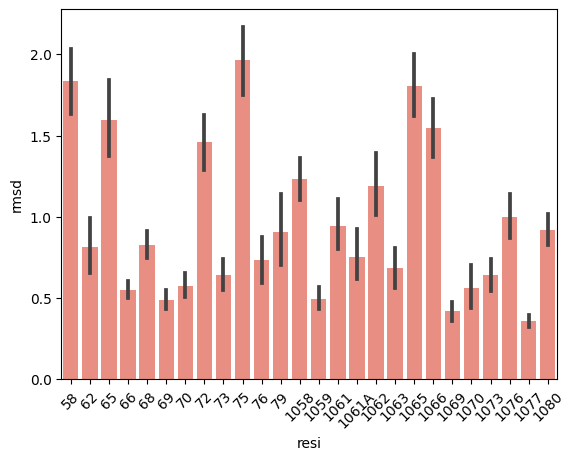

In [143]:
sns.barplot(mhc_contact_results.sort_values('residue_seq_id'),
            x='resi',
            y='rmsd',
            color='salmon')
plt.xticks(rotation=45)
print()
# plt.savefig('figures/mhc-contact-rmsd.svg')

## Correlating contact position movement with frequency of contacts

In [121]:
contacts = pd.read_csv('/ceph/project/koohylab/bmcmaste/projects/tcr-pmhc-interface-analysis/data/apo-holo-mhc-class-I_refined_aligned/contacts.csv', index_col=0)

number_of_contacts = contacts.value_counts('resi_mhc').to_frame()
number_of_contacts.index = number_of_contacts.index.rename('resi')

number_of_contacts

/tmp/ipykernel_1351944/2389418803.py:1: DtypeWarning: Columns (4,8,21,39) have mixed types. Specify dtype option on import or set low_memory=False.
  contacts = pd.read_csv('/ceph/project/koohylab/bmcmaste/projects/tcr-pmhc-interface-analysis/data/apo-holo-mhc-class-I_refined_aligned/contacts.csv', index_col=0)


,count
resi,
1066,4939
65,4107
72,3714
66,2694
1061A,2071
1062,2003
69,1989
1065,1931
76,1444


In [126]:
correlation = pd.concat([number_of_contacts, mhc_contact_results.groupby('resi')['rmsd'].mean().to_frame()], axis=1).dropna()
correlation

,count,rmsd
resi,,
1066,4939,1.544815
65,4107,1.594514
72,3714,1.458530
66,2694,0.551152
1061A,2071,0.752277
1062,2003,1.189074
69,1989,0.487767
1065,1931,1.804144
76,1444,0.732915


0.13491184957983948


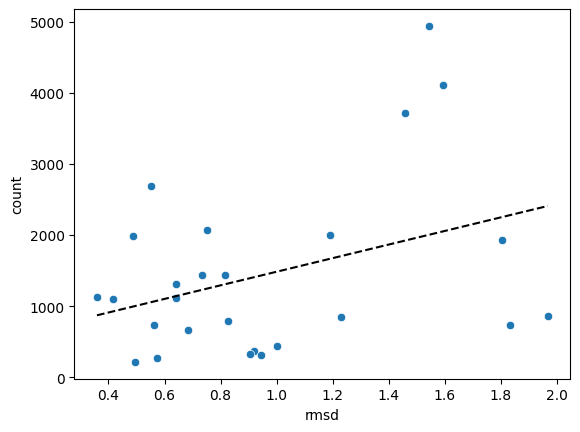

In [141]:
model = LinearRegression()
model.fit(correlation['rmsd'].to_numpy().reshape((-1, 1)),
          correlation['count'].to_numpy())

sns.scatterplot(correlation, x='rmsd', y='count')

x_reg = np.linspace(correlation['rmsd'].min(), correlation['rmsd'].max(), 10)
plt.plot(x_reg, model.coef_ * x_reg + model.intercept_, '--', color='black')

print(model.score(correlation['rmsd'].to_numpy().reshape((-1, 1)),
                  correlation['count'].to_numpy()))

## Comparing contact positions with non contact positions

In [148]:
group_names = []
apo_paths = []
holo_paths = []
residue_names = []
residue_seq_ids = []
residue_insert_codes = []
resis = []
rmsds = []

for (group_name, aligned_name), group in df.groupby(['group_name', 'aligned_to']):
    apo_structures = group.query("molecule_type == 'pmhc'")
    holo_structure_info = group.query("molecule_type == 'tcr-pmhc'").iloc[0]
    
    with open(os.path.join(DATA_DIR, holo_structure_info['path']), 'r') as fh:
        holo_df = parse_pdb_to_pandas(fh.read())
    
    holo_df['resi'] = holo_df['residue_seq_id'].apply(str) + holo_df['residue_insert_code'].fillna('')
    
    holo_mhc_df = holo_df.query('chain_id == @holo_structure_info.mhc_chain')
    
    for _, apo_structure_info in apo_structures.iterrows():
        with open(os.path.join(DATA_DIR, apo_structure_info['path']), 'r') as fh:
            apo_df = parse_pdb_to_pandas(fh.read())
        
        apo_df['resi'] = apo_df['residue_seq_id'].apply(str) + apo_df['residue_insert_code'].fillna('')
        
        apo_mhc_df = apo_df.query('chain_id == @apo_structure_info.mhc_chain')
        
        mhc_rmsds = []
        mhc_res_names = []
        mhc_res_seq_ids = []
        mhc_res_insert_codes = []
        mhc_resis = []
        
        overlap = holo_mhc_df.merge(apo_mhc_df,
                                   on=['record_type', 'resi', 'residue_seq_id', 'residue_insert_code', 'residue_name', 'atom_name', 'alt_loc'],
                                   how='inner',
                                   suffixes=['_holo', '_apo'])
        
        for (res_name, res_seq_id, res_insert_code, resi), residue_df in overlap.groupby(['residue_name', 'residue_seq_id', 'residue_insert_code', 'resi'], dropna=False):
            mhc_rmsds.append(rmsd(residue_df[['pos_x_apo', 'pos_y_apo', 'pos_z_apo']].to_numpy(),
                                  residue_df[['pos_x_holo', 'pos_y_holo', 'pos_z_holo']].to_numpy()))
            
            mhc_res_names.append(res_name)
            mhc_res_seq_ids.append(res_seq_id)
            mhc_res_insert_codes.append(res_insert_code)
            mhc_resis.append(resi)
        
        num_residues = len(mhc_rmsds)
        
        group_names += [group_name] * num_residues
        apo_paths += [apo_structure_info['path']] * num_residues
        holo_paths += [holo_structure_info['path']] * num_residues
        
        residue_names += mhc_res_names
        mhc_res_seq_ids
        residue_seq_ids += mhc_res_seq_ids
        residue_insert_codes += mhc_res_insert_codes
        resis += mhc_resis
        
        rmsds += mhc_rmsds

mhc_results = pd.DataFrame({
    'group_name': group_names,
    'apo_path': apo_paths,
    'holo_path': holo_paths,
    'residue_name': residue_names,
    'residue_seq_id': residue_seq_ids,
    'residue_insert_code': residue_insert_codes,
    'resi': resis,
    'rmsd': rmsds,
})
mhc_results['contact_position'] = mhc_results['resi'].map(lambda resi: resi in contact_positions)

mhc_results

,group_name,apo_path,holo_path,residue_name,residue_seq_id,residue_insert_code,resi,rmsd,contact_position
0,h2_dd_rgpgrafvti_NSAFDY-ILSVSNK-AASASFGDNSKLI-...,h2_dd_rgpgrafvti_NSAFDY-ILSVSNK-AASASFGDNSKLI-...,h2_dd_rgpgrafvti_NSAFDY-ILSVSNK-AASASFGDNSKLI-...,ALA,11,NaN,11,0.278014,False
1,h2_dd_rgpgrafvti_NSAFDY-ILSVSNK-AASASFGDNSKLI-...,h2_dd_rgpgrafvti_NSAFDY-ILSVSNK-AASASFGDNSKLI-...,h2_dd_rgpgrafvti_NSAFDY-ILSVSNK-AASASFGDNSKLI-...,ALA,40,NaN,40,1.000298,False
2,h2_dd_rgpgrafvti_NSAFDY-ILSVSNK-AASASFGDNSKLI-...,h2_dd_rgpgrafvti_NSAFDY-ILSVSNK-AASASFGDNSKLI-...,h2_dd_rgpgrafvti_NSAFDY-ILSVSNK-AASASFGDNSKLI-...,ALA,49,NaN,49,0.697753,False
3,h2_dd_rgpgrafvti_NSAFDY-ILSVSNK-AASASFGDNSKLI-...,h2_dd_rgpgrafvti_NSAFDY-ILSVSNK-AASASFGDNSKLI-...,h2_dd_rgpgrafvti_NSAFDY-ILSVSNK-AASASFGDNSKLI-...,ALA,67,NaN,67,0.424654,False
4,h2_dd_rgpgrafvti_NSAFDY-ILSVSNK-AASASFGDNSKLI-...,h2_dd_rgpgrafvti_NSAFDY-ILSVSNK-AASASFGDNSKLI-...,h2_dd_rgpgrafvti_NSAFDY-ILSVSNK-AASASFGDNSKLI-...,ALA,81,NaN,81,0.569454,False
...,...,...,...,...,...,...,...,...,...
14278,hla_b_53_01_qasqevknw_DSAIYN-IQSSQRE-AQLNQAGTA...,hla_b_53_01_qasqevknw_DSAIYN-IQSSQRE-AQLNQAGTA...,hla_b_53_01_qasqevknw_DSAIYN-IQSSQRE-AQLNQAGTA...,VAL,25,NaN,25,0.187199,False
14279,hla_b_53_01_qasqevknw_DSAIYN-IQSSQRE-AQLNQAGTA...,hla_b_53_01_qasqevknw_DSAIYN-IQSSQRE-AQLNQAGTA...,hla_b_53_01_qasqevknw_DSAIYN-IQSSQRE-AQLNQAGTA...,VAL,28,NaN,28,1.302418,False
14280,hla_b_53_01_qasqevknw_DSAIYN-IQSSQRE-AQLNQAGTA...,hla_b_53_01_qasqevknw_DSAIYN-IQSSQRE-AQLNQAGTA...,hla_b_53_01_qasqevknw_DSAIYN-IQSSQRE-AQLNQAGTA...,VAL,34,NaN,34,0.231340,False
14281,hla_b_53_01_qasqevknw_DSAIYN-IQSSQRE-AQLNQAGTA...,hla_b_53_01_qasqevknw_DSAIYN-IQSSQRE-AQLNQAGTA...,hla_b_53_01_qasqevknw_DSAIYN-IQSSQRE-AQLNQAGTA...,VAL,1063,NaN,1063,0.572499,True


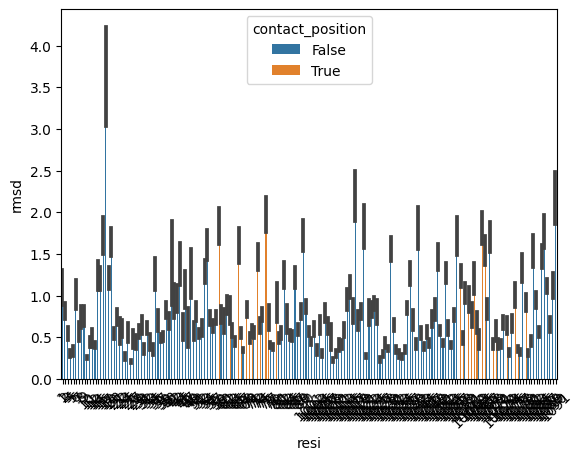

In [149]:
sns.barplot(mhc_results.sort_values('residue_seq_id'),
            x='resi',
            y='rmsd',
            hue='contact_position')
plt.xticks(rotation=45)
print()

<Axes: xlabel='contact_position', ylabel='rmsd'>

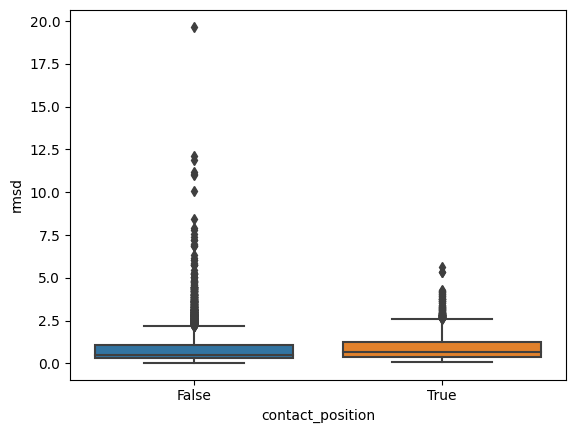

In [150]:
sns.boxplot(mhc_results, y='rmsd', x='contact_position')

In [158]:
def assign_domain_type(contact_position, peptide):
    if contact_position and not pd.isna(contact_position):
        return 'MHC Contact Position'
    
    if not pd.isna(peptide):
        return 'Peptide'
    
    return 'MHC'

peptide_results['peptide'] = True
merged = pd.concat([mhc_results, peptide_results])

merged['domain_type'] = merged.apply(lambda row: assign_domain_type(row['contact_position'], row['peptide']), axis=1)

merged

,group_name,apo_path,holo_path,residue_name,residue_seq_id,residue_insert_code,resi,rmsd,contact_position,residue_position,peptide_length,peptide,domain_type
0,h2_dd_rgpgrafvti_NSAFDY-ILSVSNK-AASASFGDNSKLI-...,h2_dd_rgpgrafvti_NSAFDY-ILSVSNK-AASASFGDNSKLI-...,h2_dd_rgpgrafvti_NSAFDY-ILSVSNK-AASASFGDNSKLI-...,ALA,11,NaN,11,0.278014,False,NaN,NaN,NaN,MHC
1,h2_dd_rgpgrafvti_NSAFDY-ILSVSNK-AASASFGDNSKLI-...,h2_dd_rgpgrafvti_NSAFDY-ILSVSNK-AASASFGDNSKLI-...,h2_dd_rgpgrafvti_NSAFDY-ILSVSNK-AASASFGDNSKLI-...,ALA,40,NaN,40,1.000298,False,NaN,NaN,NaN,MHC
2,h2_dd_rgpgrafvti_NSAFDY-ILSVSNK-AASASFGDNSKLI-...,h2_dd_rgpgrafvti_NSAFDY-ILSVSNK-AASASFGDNSKLI-...,h2_dd_rgpgrafvti_NSAFDY-ILSVSNK-AASASFGDNSKLI-...,ALA,49,NaN,49,0.697753,False,NaN,NaN,NaN,MHC
3,h2_dd_rgpgrafvti_NSAFDY-ILSVSNK-AASASFGDNSKLI-...,h2_dd_rgpgrafvti_NSAFDY-ILSVSNK-AASASFGDNSKLI-...,h2_dd_rgpgrafvti_NSAFDY-ILSVSNK-AASASFGDNSKLI-...,ALA,67,NaN,67,0.424654,False,NaN,NaN,NaN,MHC
4,h2_dd_rgpgrafvti_NSAFDY-ILSVSNK-AASASFGDNSKLI-...,h2_dd_rgpgrafvti_NSAFDY-ILSVSNK-AASASFGDNSKLI-...,h2_dd_rgpgrafvti_NSAFDY-ILSVSNK-AASASFGDNSKLI-...,ALA,81,NaN,81,0.569454,False,NaN,NaN,NaN,MHC
...,...,...,...,...,...,...,...,...,...,...,...,...,...
741,hla_b_53_01_qasqevknw_DSAIYN-IQSSQRE-AQLNQAGTA...,hla_b_53_01_qasqevknw_DSAIYN-IQSSQRE-AQLNQAGTA...,hla_b_53_01_qasqevknw_DSAIYN-IQSSQRE-AQLNQAGTA...,GLU,5,NaN,NaN,NaN,NaN,5.0,9.0,True,Peptide
742,hla_b_53_01_qasqevknw_DSAIYN-IQSSQRE-AQLNQAGTA...,hla_b_53_01_qasqevknw_DSAIYN-IQSSQRE-AQLNQAGTA...,hla_b_53_01_qasqevknw_DSAIYN-IQSSQRE-AQLNQAGTA...,LYS,7,NaN,NaN,0.679370,NaN,6.0,9.0,True,Peptide
743,hla_b_53_01_qasqevknw_DSAIYN-IQSSQRE-AQLNQAGTA...,hla_b_53_01_qasqevknw_DSAIYN-IQSSQRE-AQLNQAGTA...,hla_b_53_01_qasqevknw_DSAIYN-IQSSQRE-AQLNQAGTA...,SER,3,NaN,NaN,0.329385,NaN,7.0,9.0,True,Peptide
744,hla_b_53_01_qasqevknw_DSAIYN-IQSSQRE-AQLNQAGTA...,hla_b_53_01_qasqevknw_DSAIYN-IQSSQRE-AQLNQAGTA...,hla_b_53_01_qasqevknw_DSAIYN-IQSSQRE-AQLNQAGTA...,TRP,9,NaN,NaN,0.451805,NaN,8.0,9.0,True,Peptide


<Axes: xlabel='domain_type', ylabel='rmsd'>

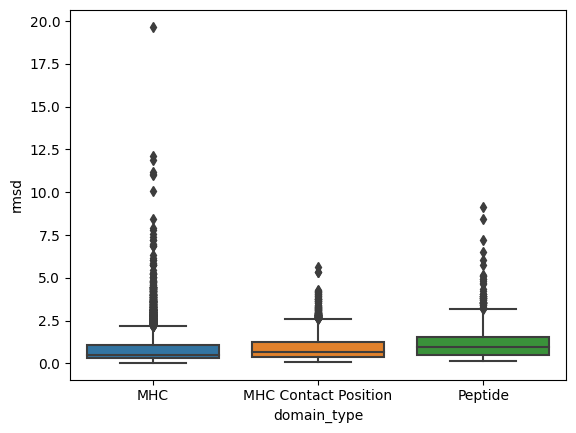

In [159]:
sns.boxplot(merged, y='rmsd', x='domain_type')